# Ukol 3: predikce cen akcii
18.6. Matyas Vondra

Predikuji cenu akcii AAPL pomoci cen AAPL, META, GOOGL, AMZN a MSFT

### Priprava dat

In [319]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [320]:
import yfinance as yf
import pandas as pd
tickers_list = ["AAPL", "META", "GOOGL", "AMZN", "MSFT"]

# Stažení dat:
import yfinance as yf
data = yf.download(tickers_list,'2018-1-1')['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [321]:
data

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2018-01-02,40.831585,59.450500,53.660500,181.419998,80.562042
2018-01-03,40.824482,60.209999,54.576000,184.669998,80.936974
2018-01-04,41.014103,60.479500,54.787998,184.330002,81.649345
2018-01-05,41.481064,61.457001,55.514500,186.850006,82.661629
2018-01-08,41.326992,62.343498,55.710499,188.279999,82.745987
...,...,...,...,...,...
2023-06-12,183.789993,126.570000,123.639999,271.049988,331.850006
2023-06-13,183.309998,126.660004,123.830002,271.320007,334.290009
2023-06-14,183.949997,126.419998,123.669998,273.350006,337.339996


In [381]:
prices = data.values.reshape(-1,1) # prevod na array

In [323]:
prices = (np.log(prices)) # logaritmus cen, kvuli volatilite

In [324]:
prices.shape # petinasobek poctu radku puvodnich dat

(6870, 1)

In [325]:
# Normalizace dat
scaler = MinMaxScaler(feature_range=(0, 1))
prices = scaler.fit_transform(prices)

### 10 % testovacich dat

In [382]:
# Rozdělení dat na trénovací a testovací sady
train_size = int(len(prices) * 0.90)
train, test = prices[0:train_size, :], prices[train_size:len(prices), :]

In [327]:
train

array([[0.07331607],
       [0.22898526],
       [0.18652734],
       ...,
       [0.58612533],
       [0.41179952],
       [0.42403613]])

In [328]:
# Funkce pro vytvoření datové sady pro LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    # zde uprava range pro 5 promennych:
    for i in range(0, len(dataset) - look_back - 1, 5):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [383]:
# Vytvoření trénovací a testovací sady
look_back = 5*2  # časový okamžik do minulosti
# v pripade predikce 10% dat mi nevychazely moc dobre vysledky
# s dlouhym look_back. Pouzivam tedy pouze dva dny dozadu

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

Toto jsem vytvoril bez logaritmovani a standardizace pro overeni spravne tvorby X a Y.

V tomto pripade predikujeme AAPL na 5 pozorovani dozadu, tedy ze vsech akcii z jednoho predchoziho dne

In [384]:
trainX[1]

array([ 40.82448196,  60.20999908,  54.57600021, 184.66999817,
        80.93697357])

In [385]:
trainY[1]

41.014102935791016

In [373]:
# Změna tvaru vstupních dat
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [374]:
trainX.shape # pocet pozorovani, pocet promennych, pocet pozorovani do minulosti

(1303, 1, 10)

In [375]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Vytvoření a kompilace LSTM modelu
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(2))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 4)                 240       
                                                                 
 dense_45 (Dense)            (None, 2)                 10        
                                                                 
 dropout_18 (Dropout)        (None, 2)                 0         
                                                                 
 dense_46 (Dense)            (None, 1)                 3         
                                                                 
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________


In [376]:
# Trénování modelu
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
1303/1303 [==============================] - 6s 2ms/step - loss: 0.0278
Epoch 2/100
1303/1303 [==============================] - 4s 3ms/step - loss: 0.0091
Epoch 3/100
1303/1303 [==============================] - 3s 2ms/step - loss: 0.0066
Epoch 4/100
1303/1303 [==============================] - 3s 2ms/step - loss: 0.0065
Epoch 5/100
1303/1303 [==============================] - 3s 2ms/step - loss: 0.0060
Epoch 6/100
1303/1303 [==============================] - 4s 3ms/step - loss: 0.0059
Epoch 7/100
1303/1303 [==============================] - 3s 2ms/step - loss: 0.0059
Epoch 8/100
1303/1303 [==============================] - 3s 3ms/step - loss: 0.0057
Epoch 9/100
1303/1303 [==============================] - 3s 2ms/step - loss: 0.0063
Epoch 10/100
1303/1303 [==============================] - 4s 3ms/step - loss: 0.0050
Epoch 11/100
1303/1303 [==============================] - 3s 2ms/step - loss: 0.0055
Epoch 12/100
1303/1303 [==============================] - 3s 2ms/step - lo

In [336]:
# Predikce cen
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverzní transformace predikcí a skutečných hodnot pro zpětné porovnání
trainPredict = scaler.inverse_transform(trainPredict)
trainY_i = scaler.inverse_transform([trainY])


5/5 [==============================] - 0s 2ms/step


In [337]:
# Inverzní transformace testovacích dat
testYr = scaler.inverse_transform([testY])[0]
testPredictr = scaler.inverse_transform(testPredict)
testPredictr= [i[0] for i in testPredictr]

In [338]:
# Výpočet MAPE v logaritmech
mape = np.mean(np.abs((testYr - testPredictr) / testYr)) * 100
print(f"MAPE: {mape}%")

MAPE: 2.013097930425758%


In [339]:
# Výpočet MAPE v reálných hodnotách
mape = np.mean(np.abs((np.exp(testYr) - np.exp(testPredictr)) / np.exp(testYr))) * 100
print(f"MAPE: {mape}%")

MAPE: 10.024492160249816%


In [340]:
# pozor je to v procentech!!

In [341]:
import matplotlib.pyplot as plt

<Axes: >

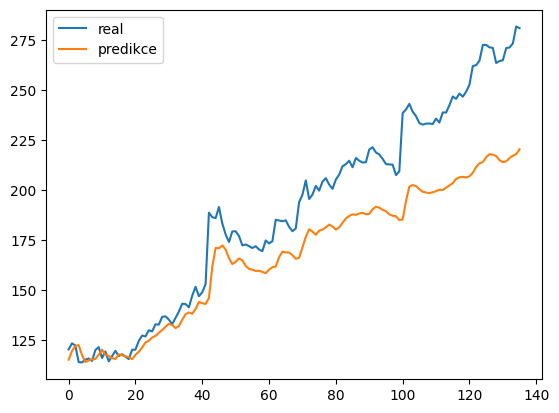

In [342]:
pd.DataFrame({"real": np.exp(testYr), "predikce": np.exp(testPredictr)}).plot()

### 5% testovacich dat

S vetsim mnozstvim trenovacich dat bylo mozne pouzit vetsi lookback

In [343]:
# Rozdělení dat na trénovací a testovací sady
train_size = int(len(prices) * 0.95)
train, test = prices[0:train_size, :], prices[train_size:len(prices), :]

In [344]:
# Vytvoření trénovací a testovací sady
look_back = 5*10  # časový okamžik do minulosti 10 dni
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [345]:
# Změna tvaru vstupních dat
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [346]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Vytvoření a kompilace LSTM modelu
model = Sequential()
model.add(LSTM(28, input_shape=(1, look_back)))
model.add(Dense(14))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 28)                8848      
                                                                 
 dense_41 (Dense)            (None, 14)                406       
                                                                 
 dropout_17 (Dropout)        (None, 14)                0         
                                                                 
 dense_42 (Dense)            (None, 1)                 15        
                                                                 
Total params: 9,269
Trainable params: 9,269
Non-trainable params: 0
_________________________________________________________________


In [347]:
# Trénování modelu
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
1295/1295 [==============================] - 6s 3ms/step - loss: 0.0078
Epoch 2/100
1295/1295 [==============================] - 3s 3ms/step - loss: 0.0034
Epoch 3/100
1295/1295 [==============================] - 4s 3ms/step - loss: 0.0026
Epoch 4/100
1295/1295 [==============================] - 5s 3ms/step - loss: 0.0021
Epoch 5/100
1295/1295 [==============================] - 4s 3ms/step - loss: 0.0015
Epoch 6/100
1295/1295 [==============================] - 3s 2ms/step - loss: 0.0016
Epoch 7/100
1295/1295 [==============================] - 3s 2ms/step - loss: 0.0014
Epoch 8/100
1295/1295 [==============================] - 4s 3ms/step - loss: 0.0015
Epoch 9/100
1295/1295 [==============================] - 3s 2ms/step - loss: 0.0014
Epoch 10/100
1295/1295 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 11/100
1295/1295 [==============================] - 3s 2ms/step - loss: 0.0013
Epoch 12/100
1295/1295 [==============================] - 4s 3ms/step - lo

In [348]:
# Predikce cen
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverzní transformace predikcí a skutečných hodnot pro zpětné porovnání
trainPredict = scaler.inverse_transform(trainPredict)
trainY_i = scaler.inverse_transform([trainY])

2/2 [==============================] - 0s 5ms/step


In [349]:
# Inverzní transformace testovacích dat
testYr = scaler.inverse_transform([testY])[0]
testPredictr = scaler.inverse_transform(testPredict)
testPredictr= [i[0] for i in testPredictr]

In [350]:
# Výpočet MAPE v logaritmech
mape = np.mean(np.abs((testYr - testPredictr) / testYr)) * 100
print(f"MAPE: {mape}%")

MAPE: 2.7623599757343724%


In [351]:
# Výpočet MAPE v reálných hodnotách
mape = np.mean(np.abs((np.exp(testYr) - np.exp(testPredictr)) / np.exp(testYr))) * 100
print(f"MAPE: {mape}%")

MAPE: 13.875089123790977%


In [352]:
# pozor je to v procentech!!

In [353]:
import matplotlib.pyplot as plt

<Axes: >

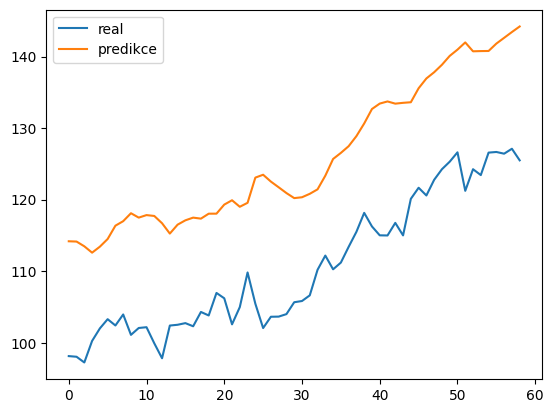

In [354]:
pd.DataFrame({"real": np.exp(testYr), "predikce": np.exp(testPredictr)}).plot()

### Porovnani s 1D konvoluci

In [355]:
import pandas as pd
import numpy as np

def create_lagged_dataset(series, n_lags):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)

    df = pd.DataFrame()

    for i in range(n_lags + 1):
        df['lag_' + str(i)] = series.shift(i)

    df = df.iloc[n_lags:]

    return df

In [356]:
y= prices
ymax = max(y)
ymin = min(y)
y = [(i-ymin)/(ymax - ymin) for i in y]
price_data = create_lagged_dataset(y, 10)

In [357]:
price_data.shape

(6860, 11)

In [358]:
price_data # kazda hodnota je vysvetlena deveti predchozimi

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
10,[0.07516413350634044],[0.35682561747745],[0.6986289892416693],[0.19353705750033345],[0.23424528114744958],[0.07324398759854445],[0.354901693813775],[0.691271796964458],[0.18652734077073085],[0.228985263595886],[0.07331607452277411]
11,[0.23609581223339626],[0.07516413350634044],[0.35682561747745],[0.6986289892416693],[0.19353705750033345],[0.23424528114744958],[0.07324398759854445],[0.354901693813775],[0.691271796964458],[0.18652734077073085],[0.228985263595886]
12,[0.1951434922730173],[0.23609581223339626],[0.07516413350634044],[0.35682561747745],[0.6986289892416693],[0.19353705750033345],[0.23424528114744958],[0.07324398759854445],[0.354901693813775],[0.691271796964458],[0.18652734077073085]
13,[0.6978654116174101],[0.1951434922730173],[0.23609581223339626],[0.07516413350634044],[0.35682561747745],[0.6986289892416693],[0.19353705750033345],[0.23424528114744958],[0.07324398759854445],[0.354901693813775],[0.691271796964458]
14,[0.3604566548012589],[0.6978654116174101],[0.1951434922730173],[0.23609581223339626],[0.07516413350634044],[0.35682561747745],[0.6986289892416693],[0.19353705750033345],[0.23424528114744958],[0.07324398759854445],[0.354901693813775]
...,...,...,...,...,...,...,...,...,...,...,...
6865,[0.6991895530624417],[0.9612982347395551],[0.8737918118967314],[0.5372214169587712],[0.5438591792524785],[0.7016247805395412],[0.9482880311049602],[0.8611327938152313],[0.5324908067963106],[0.5416037586526352],[0.6970103126233145]
6866,[0.5385442980823325],[0.6991895530624417],[0.9612982347395551],[0.8737918118967314],[0.5372214169587712],[0.5438591792524785],[0.7016247805395412],[0.9482880311049602],[0.8611327938152313],[0.5324908067963106],[0.5416037586526352]
6867,[0.532021471814939],[0.5385442980823325],[0.6991895530624417],[0.9612982347395551],[0.8737918118967314],[0.5372214169587712],[0.5438591792524785],[0.7016247805395412],[0.9482880311049602],[0.8611327938152313],[0.5324908067963106]
6868,[0.8725697327014563],[0.532021471814939],[0.5385442980823325],[0.6991895530624417],[0.9612982347395551],[0.8737918118967314],[0.5372214169587712],[0.5438591792524785],[0.7016247805395412],[0.9482880311049602],[0.8611327938152313]


In [359]:
X = np.array(price_data.loc[:, price_data.columns  != "lag_0"])
Y = np.array(price_data["lag_0"])

In [360]:
X.shape

(6860, 10)

In [361]:
X = X.reshape((X.shape[0], X.shape[1], 1)) # konvoluce vzdy potrebuji treti dimenzi

In [362]:
X.shape

(6860, 10, 1)

In [363]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [364]:
# kvuli value error: prevod array na tensor
X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
Y_test = np.asarray(Y_test).astype('float32')

In [365]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

model = Sequential()
model.add(Conv1D(64, 4, activation='relu', input_shape=(10, 1)))
model.add(Conv1D(16, 3, activation='relu'))
model.add(Conv1D(8, 2, activation='relu'))
model.add(Flatten()) # zplosteni, ze tri dimenzi zase do klasicke matice
model.add(Dense(32, activation='relu')) # klasicka skrya vrstva
model.add(Dense(1, activation='relu')) # vystupni funkce, 1 neuron

model.compile(loss='mae', optimizer="adam")

model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 7, 64)             320       
                                                                 
 conv1d_13 (Conv1D)          (None, 5, 16)             3088      
                                                                 
 conv1d_14 (Conv1D)          (None, 4, 8)              264       
                                                                 
 flatten_3 (Flatten)         (None, 32)                0         
                                                                 
 dense_43 (Dense)            (None, 32)                1056      
                                                                 
 dense_44 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,761
Trainable params: 4,761
Non-train

In [366]:
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
172/172 [==============================] - 40s 3ms/step - loss: 0.0876
Epoch 2/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 3/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 4/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 5/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 6/100
172/172 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 7/100
172/172 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 8/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 9/100
172/172 [==============================] - 1s 4ms/step - loss: 0.0083
Epoch 10/100
172/172 [==============================] - 1s 4ms/step - loss: 0.0079
Epoch 11/100
172/172 [==============================] - 1s 4ms/step - loss: 0.0080
Epoch 12/100
172/172 [==============================] - 1s 3ms/step - loss: 0.0077
Epoch 13/100

In [367]:
# Predikce cen
testPredict = model.predict(X_test)

43/43 [==============================] - 0s 2ms/step


In [368]:
# Inverzní transformace testovacích dat
testYr = scaler.inverse_transform([Y_test])[0]
testPredictr = scaler.inverse_transform(testPredict)
testPredictr= [i[0] for i in testPredictr]

In [369]:
# Výpočet MAPE v logaritmech
mape = np.mean(np.abs((testYr - testPredictr) / testYr)) * 100
print(f"MAPE: {mape}%")

MAPE: 0.5568657475726406%


In [370]:
# Výpočet MAPE v reálných hodnotách
mape = np.mean(np.abs((np.exp(testYr) - np.exp(testPredictr)) / np.exp(testYr))) * 100
print(f"MAPE: {mape}%")

MAPE: 2.6915640511107406%


Metriky byly sice vyborne, ale nejsem si jisty, jestli vse funguje jak ma. Graf je bohuzel uplny binec

<Axes: >

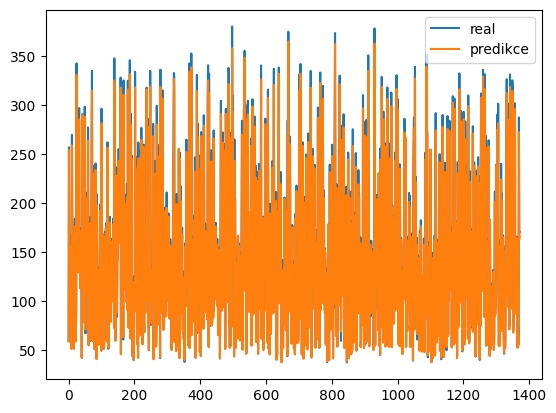

In [371]:
pd.DataFrame({"real": np.exp(testYr), "predikce": np.exp(testPredictr)}).plot()